In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import sys

import momepy
import networkx as nx
from libpysal import weights

%matplotlib inline
import matplotlib.pyplot as plt

parentdir = os.path.dirname(os.getcwd())
sys.path.insert(0, parentdir)
import KeyFunctions as kf

root_path = "D:/GeoData/"
Main_CRS = "EPSG:27700"

In [2]:
gdf = kf.load_obj(root_path,"raw_gdf_StPauls")

In [185]:
Road = gdf.loc[gdf["Type"]=="Road",:].reset_index(drop=True)
A_Road = Road.loc[Road["Name"]=='A Road',:].reset_index(drop=True)

In [186]:
A_Road["Length"] = A_Road.geometry.length
A_Road

,Type,Name,Details_Str,Details_Float,geometry,Length
0,Road,A Road,A13,NaN,"LINESTRING Z (534373.000 181318.000 0.000, 534...",43.000000
1,Road,A Road,A13,NaN,"LINESTRING Z (534416.000 181318.000 0.000, 534...",4.000000
2,Road,A Road,A13,NaN,"LINESTRING Z (534420.000 181318.000 0.000, 534...",84.260727
3,Road,A Road,A13,NaN,"LINESTRING Z (534504.250 181318.850 0.000, 534...",45.787390
4,Road,A Road,A13,NaN,"LINESTRING Z (534550.000 181317.000 0.000, 534...",2.001091
...,...,...,...,...,...,...
1568,Road,A Road,A302,NaN,"LINESTRING Z (530038.580 179565.830 0.000, 530...",41.589645
1569,Road,A Road,A302,NaN,"LINESTRING Z (530038.580 179565.830 0.000, 530...",63.388212
1570,Road,A Road,A302,NaN,"LINESTRING Z (530099.000 179585.000 0.000, 530...",33.788770
1571,Road,A Road,A302,NaN,"LINESTRING Z (530067.090 179596.110 0.000, 530...",77.720868


In [110]:
def remove_multipart(in_gdf):
    gdf_a = in_gdf[in_gdf.geom_type == 'LineString']
    gdf_b = in_gdf[in_gdf.geom_type == 'MultiLineString']

    gdf_b = gdf_b.explode()

    gdf = gdf_a.append(gdf_b)
    return gdf

In [187]:
G = momepy.gdf_to_nx(remove_multipart(A_Road), approach="primal", angles=True, length="Length")

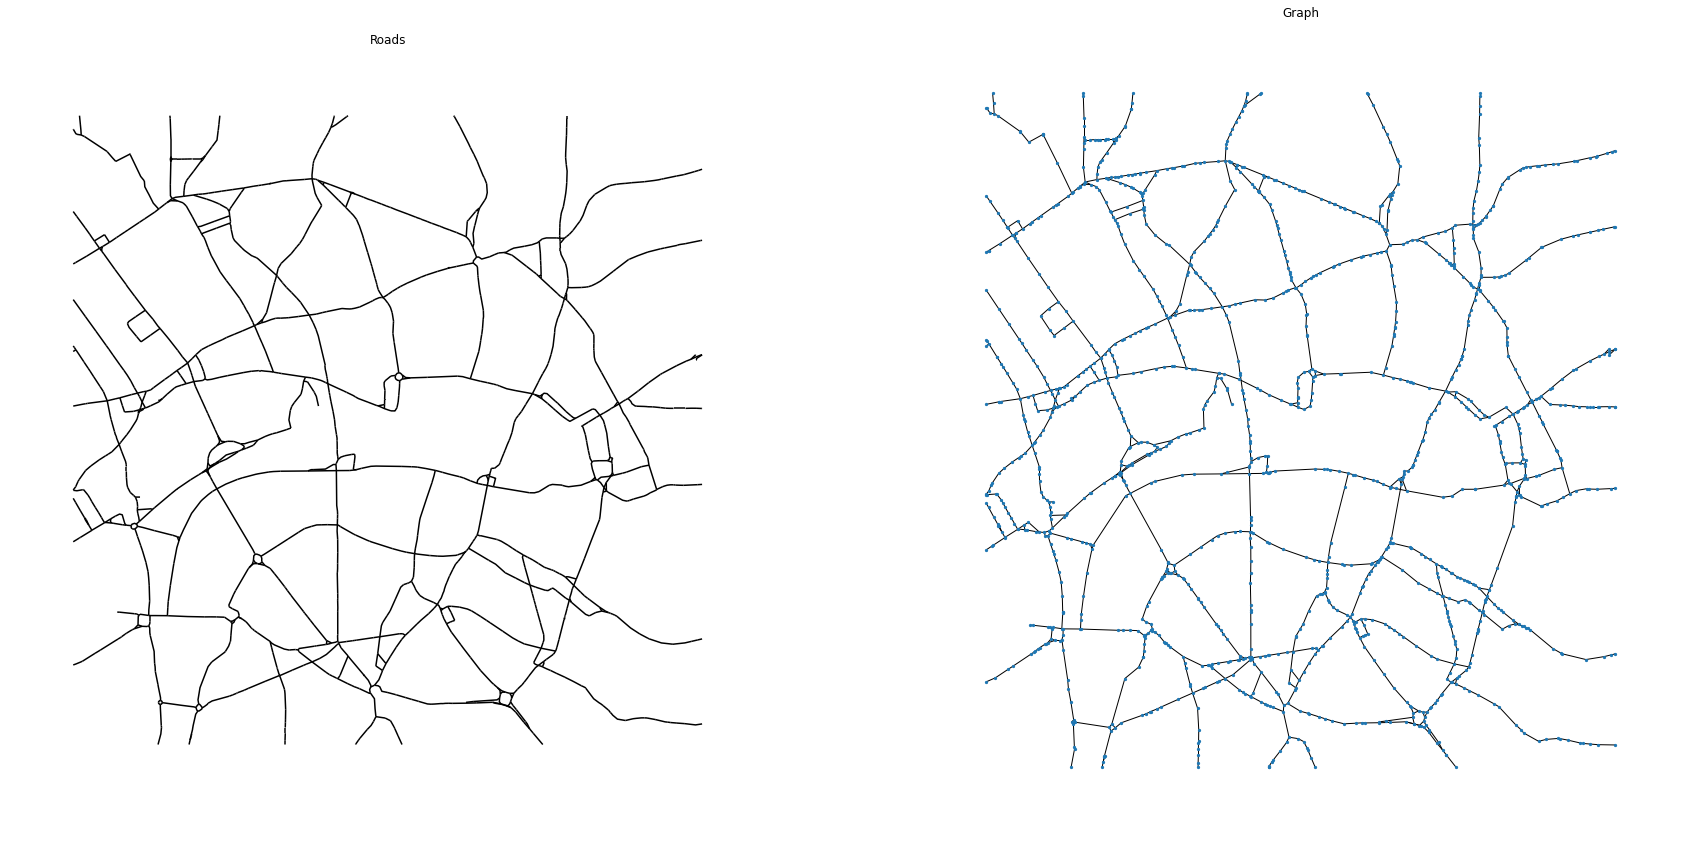

In [188]:
positions = {n: [n[0], n[1]] for n in list(G.nodes)}

# Plot
f, ax = plt.subplots(1, 2, figsize=(30, 15), sharex=True, sharey=True)
A_Road.plot(color="k", ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("Roads", "Graph")[i])
    facet.axis("off")
nx.draw(G, positions, ax=ax[1], node_size=5)

In [189]:
nodes_to_remove = [n for n in G.nodes if len(list(G.neighbors(n))) == 2]

In [190]:
G2 = G.copy()

#answer from https://stackoverflow.com/questions/56380053/combine-edges-when-node-degree-is-n-in-networkx
for node in nodes_to_remove:
    # We add an edge between neighbors (len == 2 so it is correct)
    G2.add_edge(*G2.neighbors(node))
    # And delete the node
    G2.remove_node(node)

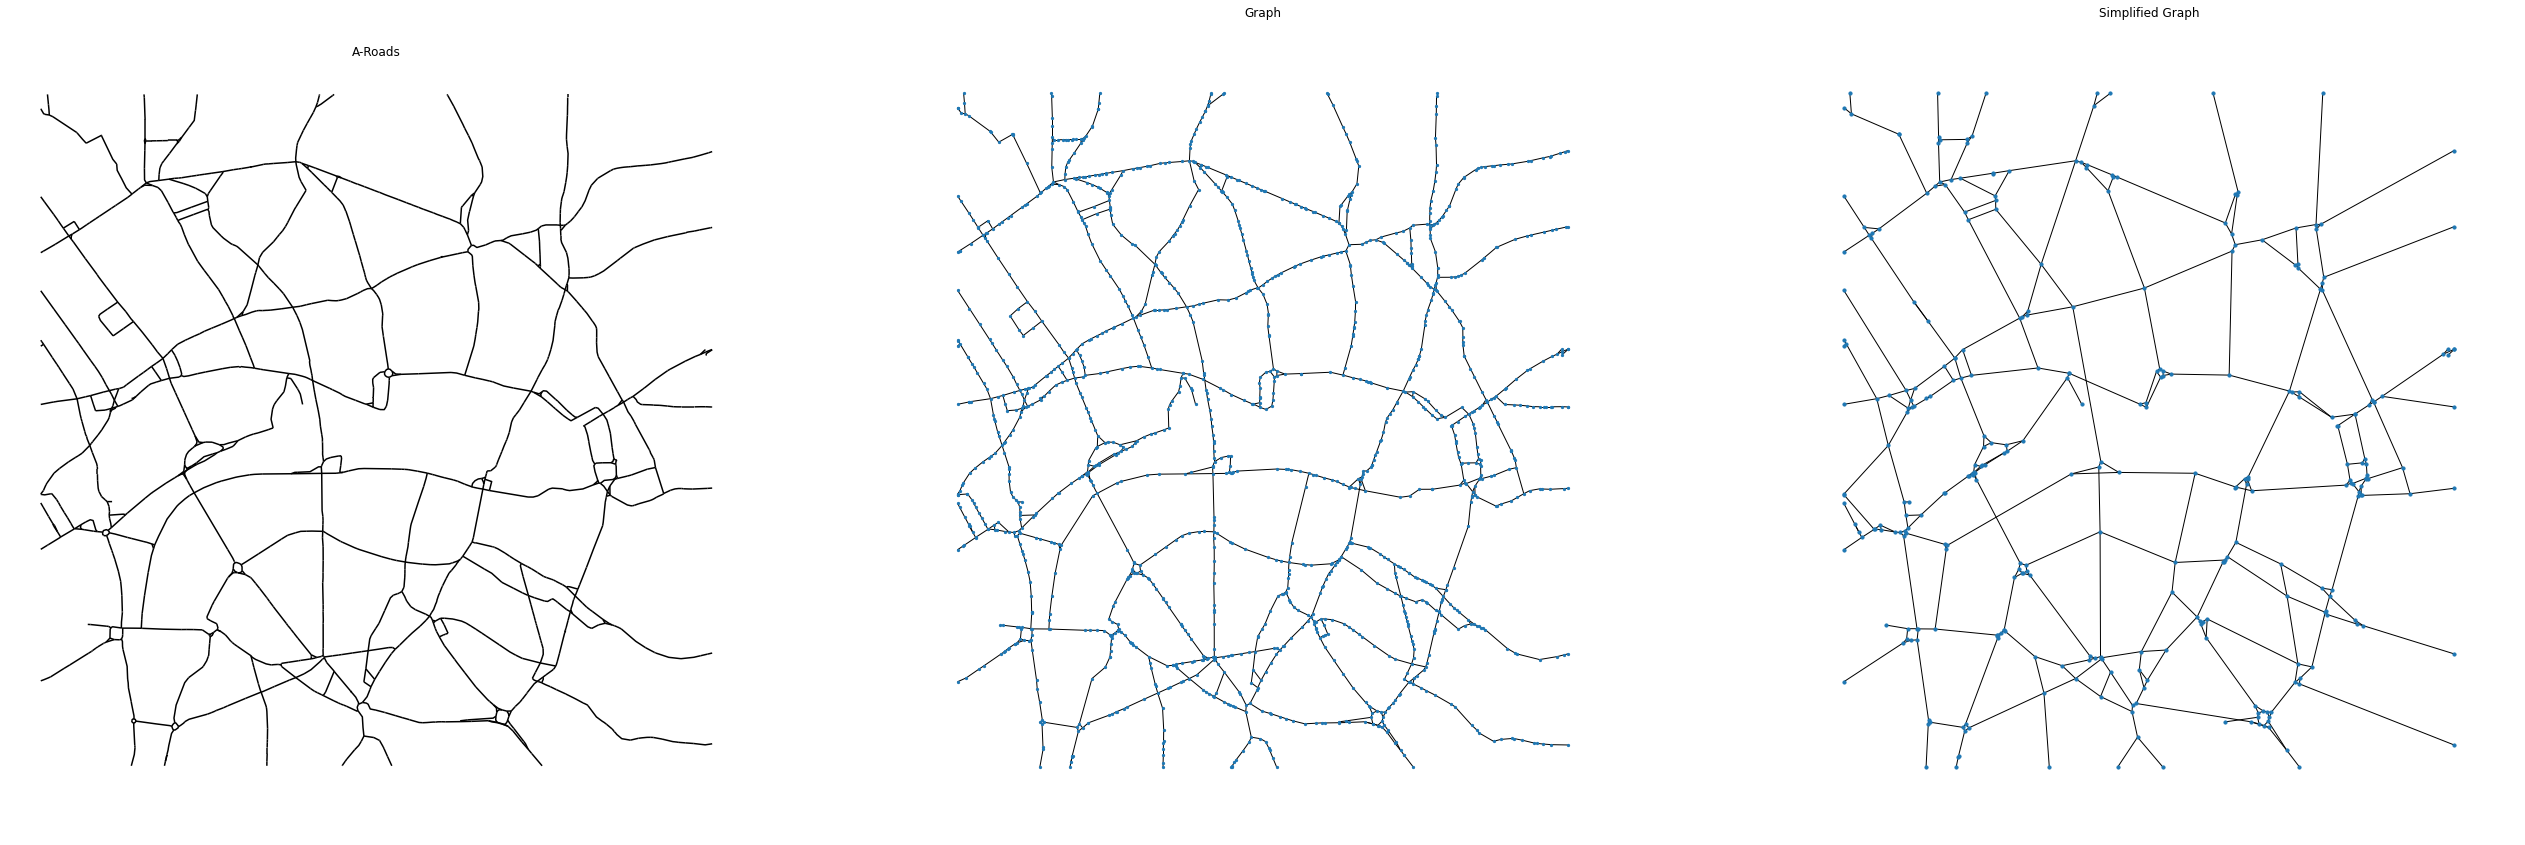

In [191]:
positions = {n: [n[0], n[1]] for n in list(G.nodes)}

# Plot
f, ax = plt.subplots(1, 3, figsize=(45, 15))
A_Road.plot(color="k", ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("A-Roads", "Graph", "Simplified Graph")[i])
    facet.axis("off")
nx.draw(G, positions, ax=ax[1], node_size=5)
nx.draw(G2, positions, ax=ax[2], node_size=10)

In [133]:
#Now lets play with some polygons

In [134]:
LSOA = gdf.loc[gdf["Type"]=="LSOA",:].reset_index(drop=True)
All_GB = gdf.loc[gdf["Type"]=="All_GB",:].reset_index(drop=True)

#Attempt methods from these places
* https://geographicdata.science/book/intro.html 
    * https://geographicdata.science/book/notebooks/04_spatial_weights.html
* https://networkx.org/documentation/stable/auto_examples/geospatial/plot_polygons.html

In [135]:
centroids = np.column_stack((LSOA.centroid.x, LSOA.centroid.y))
queen = weights.Queen.from_dataframe(LSOA)
G = queen.to_networkx()
positions = dict(zip(G.nodes, centroids))

AttributeError: 'tuple' object has no attribute 'Queen'

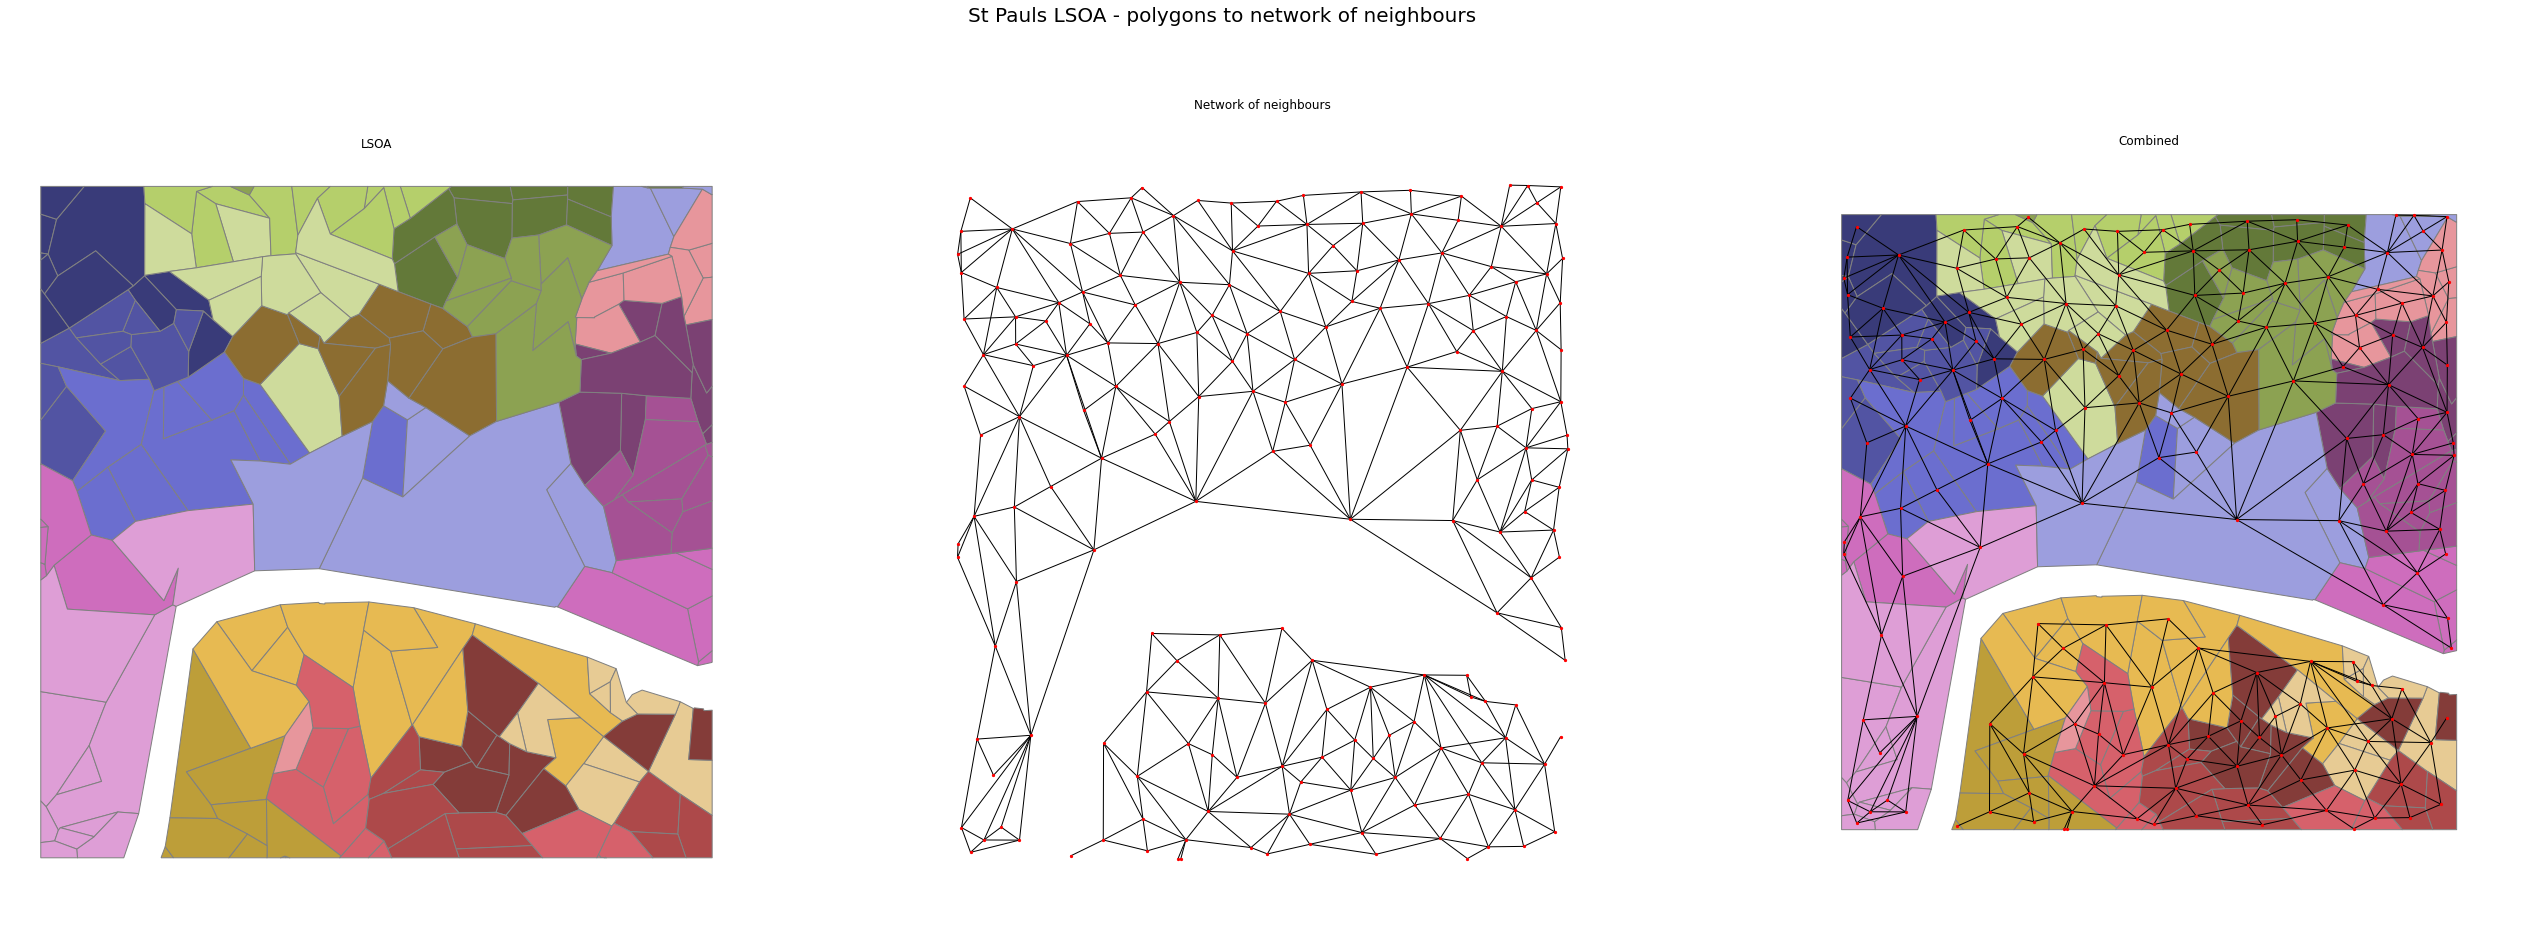

In [136]:
fig, ax = plt.subplots(1, 3, figsize=(45, 15))
fig.suptitle("St Pauls LSOA - polygons to network of neighbours", fontsize=20)

for i, facet in enumerate(ax):
    facet.set_title(("LSOA", "Network of neighbours", "Combined")[i])
    facet.axis("off")

#Plot1 - just the LSOA
LSOA.plot(ax=ax[0], edgecolor='grey', linewidth=1, column="Name", cmap='tab20b',
                                categorical=True, legend=False)

#Plot2 - just the network
nx.draw(G, positions, ax=ax[1], node_size=5, node_color="r")

#Plot 3 - combined network and graph
LSOA.plot(ax=ax[2], edgecolor='grey', linewidth=1, column="Name", cmap='tab20b',
                                categorical=True, legend=False)

nx.draw(G, positions, ax=ax[2], node_size=5, node_color="r")
plt.show()

In [137]:
LSOA["Centroid"] = centroids.tolist()

In [138]:
note_attrib = LSOA.loc[:,["Name","Centroid"]].to_dict('index')
nx.set_node_attributes(G, note_attrib)

In [139]:
def dist_node(n1, n2):
    dist = np.sqrt( (n1["Centroid"][0] - n2["Centroid"][0])**2  + (n1["Centroid"][1] - n2["Centroid"][1])**2 )
    return dist

In [140]:
dist = [dist_node(G.nodes[e[0]], G.nodes[e[1]]) for e in G.edges()]
e_attrib = pd.DataFrame(dist, columns =['Length'])
e_attrib["e"] = G.edges()
e_attrib = e_attrib.set_index("e").to_dict("index")

In [141]:
nx.set_edge_attributes(G,e_attrib)

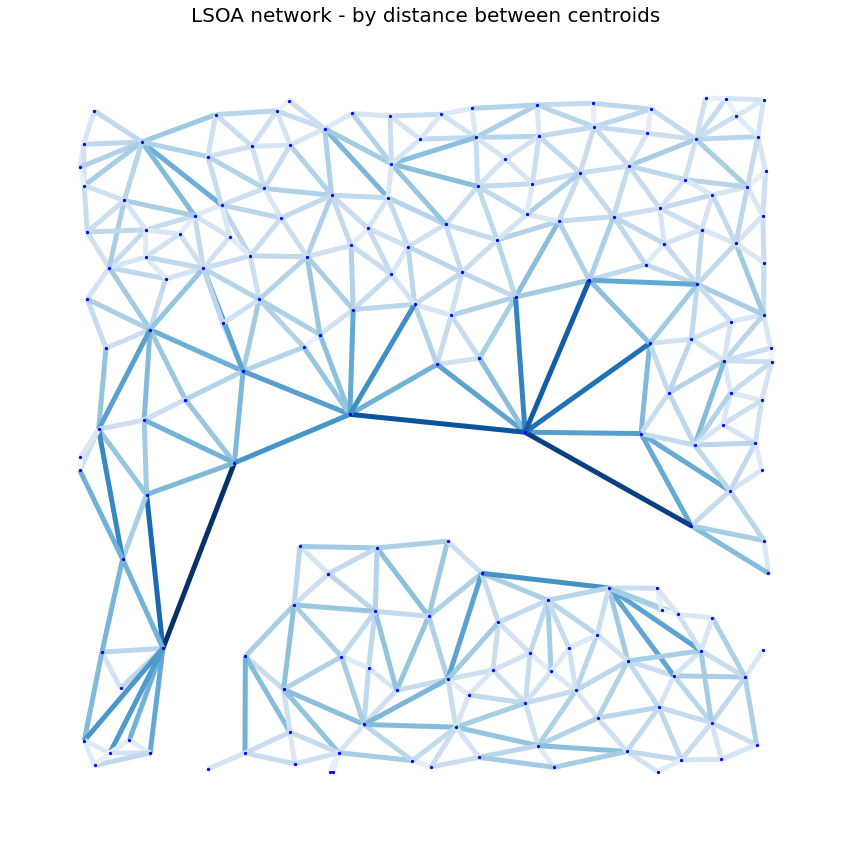

In [142]:
edges,weights = zip(*nx.get_edge_attributes(G,'Length').items())

pos = dict(zip(G.nodes, centroids))

fig, ax = plt.subplots(1, figsize=(15, 15))
ax.set_title("LSOA network - by distance between centroids", size=20)
nx.draw(G, pos, node_color='b', node_size=5, edgelist=edges, edge_color=weights, width=5.0, edge_cmap=plt.cm.Blues, ax=ax)
plt.show()

In [143]:
G.nodes[1]

{'Type': 'LSOA',
 'Centroid': [532436.1157332506, 181714.8752029019],
 'Name': 'City of London 001B'}

In [156]:
G1 = nx.ego_graph(G, 0, 1)
pos_G1 = nx.spring_layout(G1)

G2 = nx.ego_graph(G, 0, 2)
pos_G2 = nx.spring_layout(G2)

G3 = nx.ego_graph(G, 0, 3)
pos_G3 = nx.spring_layout(G3)

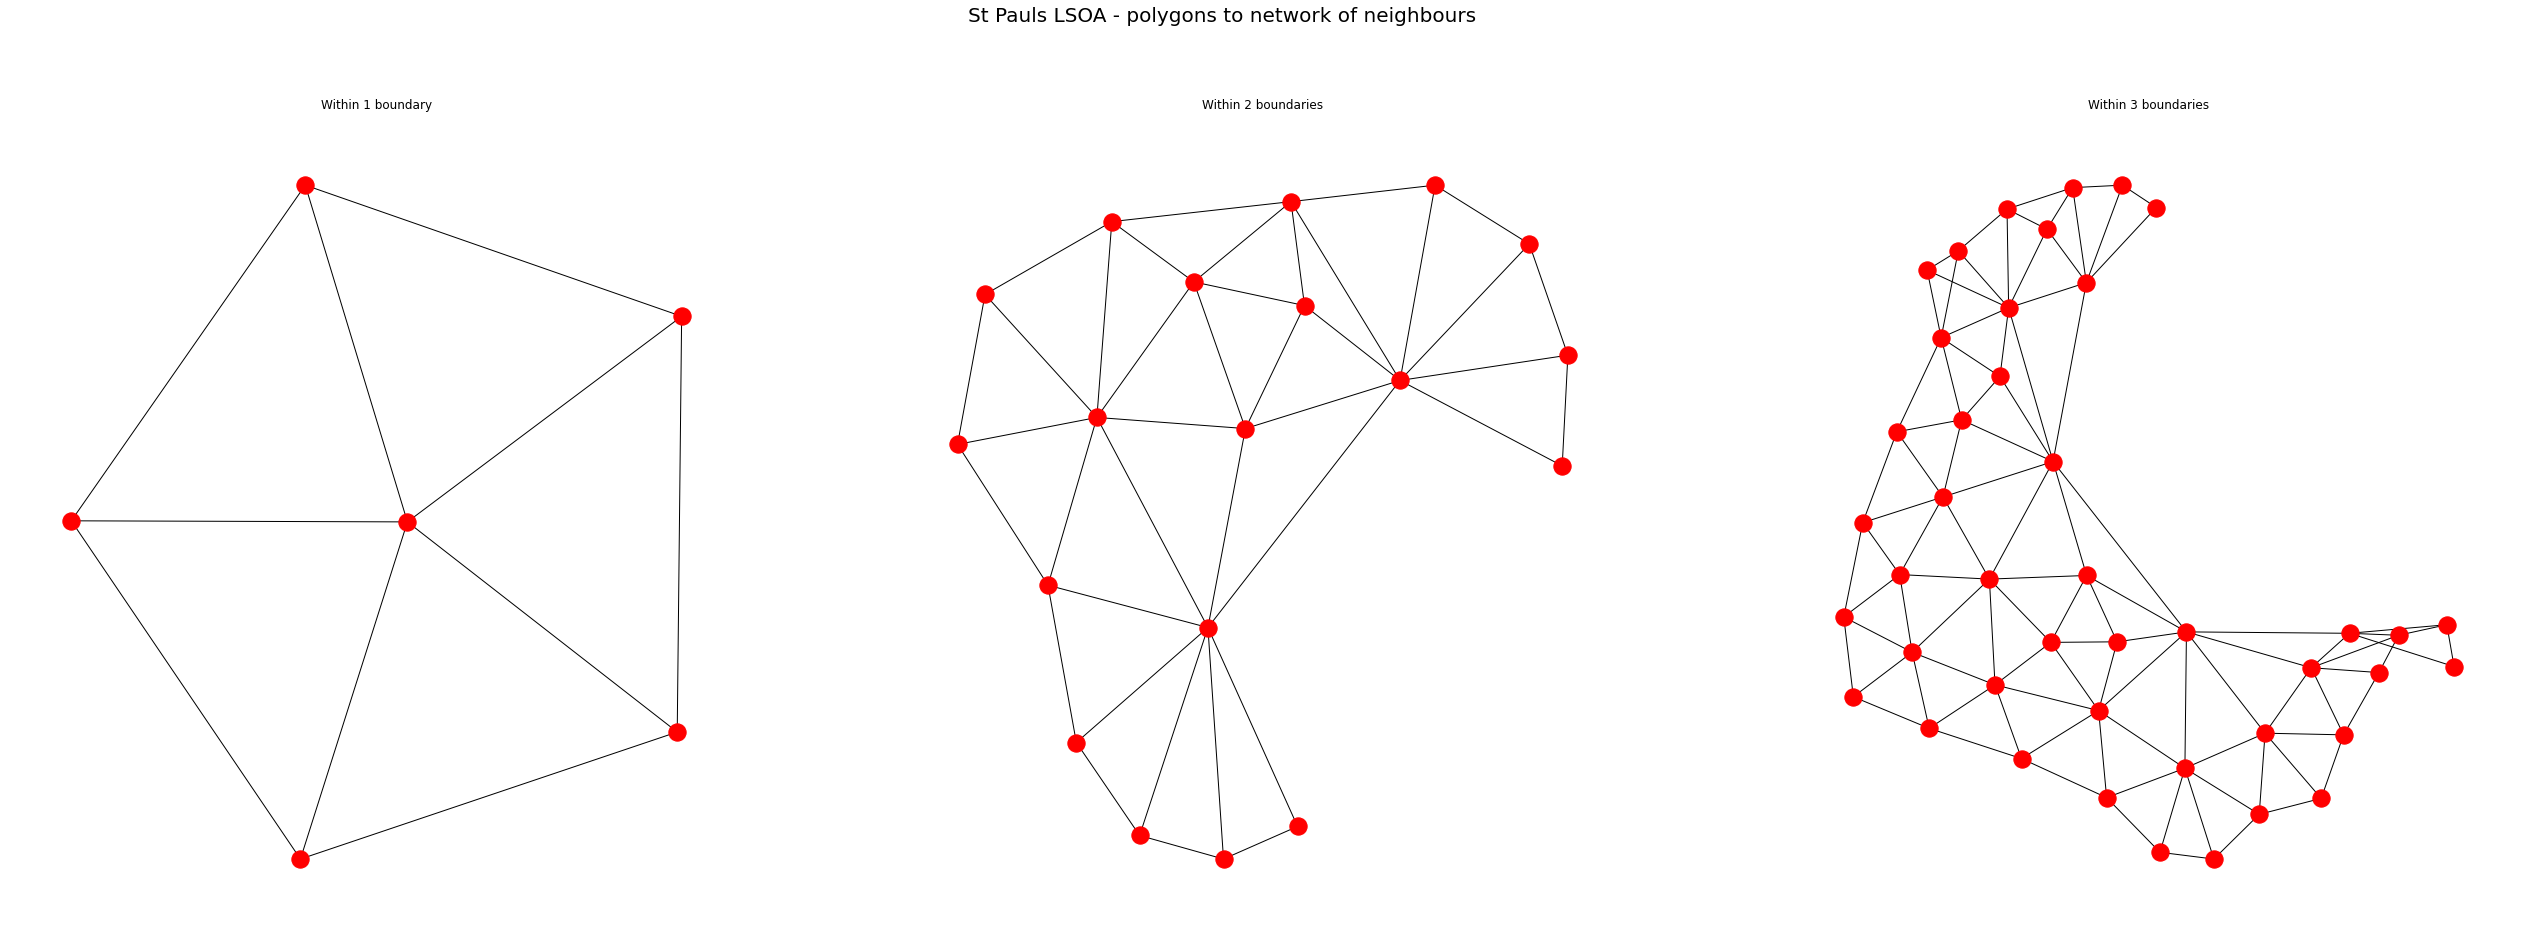

In [160]:
fig, ax = plt.subplots(1, 3, figsize=(45, 15))
fig.suptitle("St Pauls LSOA - polygons to network of neighbours", fontsize=20)

for i, facet in enumerate(ax):
    facet.set_title(("Within 1 boundary", "Within 2 boundaries", "Within 3 boundaries")[i])
    facet.axis("off")

#Plot1

nx.draw(G1, pos_G1, ax=ax[0], node_color="r")

#Plot2
nx.draw(G2, pos_G2, ax=ax[1], node_color="r")

#Plot3
nx.draw(G3, pos_G3, ax=ax[2], node_color="r")


plt.show()